In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import array as array
import os
from datetime import datetime



x_unique before [3.7013, 3.7113, 3.7246, 3.7373, 3.7503, 3.7625, 3.7747, 3.787, 3.8008, 3.8119, 3.825, 3.8368, 3.8507, 3.8624, 3.8745, 3.8874, 3.9005, 3.912, 3.9251, 3.9364, 3.951, 3.9621, 3.9747, 3.9876]
y_avg before [3.50576e-07, 3.55148e-07, 3.827e-07, 4.42812e-07, 4.9458e-07, 6.24712e-07, 8.4154e-07, 1.014652e-06, 1.207672e-06, 1.545016e-06, 1.726812e-06, 2.769884e-06, 4.37956e-06, 5.29012e-06, 5.28572e-06, 5.6526e-06, 6.30932e-06, 6.12976e-06, 6.70672e-06, 6.74808e-06, 7.00404e-06, 6.97196e-06, 6.9e-06, 6.92392e-06]
Unique x values: [0.     0.01   0.0233 0.036  0.049  0.0612 0.0734 0.0857 0.0995 0.1106
 0.1237 0.1355 0.1494 0.1611 0.1732 0.1861 0.1992 0.2107 0.2238 0.2351
 0.2497 0.2608 0.2734 0.2863]
Averaged y values: [9.87958152e-01 9.84363033e-01 9.95178451e-01 1.00000000e+00
 9.61529814e-01 9.55313503e-01 8.68597771e-01 8.95585217e-01
 7.96881745e-01 7.41740543e-01 7.42401853e-01 6.05546825e-01
 3.63616306e-01 2.06845036e-01 1.79521524e-01 1.28819514e-01
 9.98090619e-02 7.379

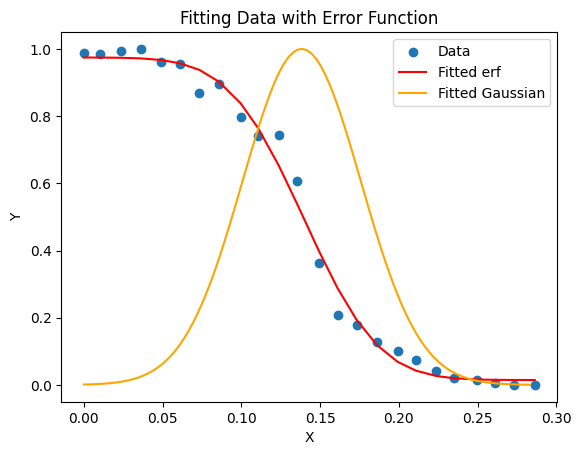

In [5]:
#actual data

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import special
from scipy.special import erfc,erf

# Define the error function model
def error_function(x, a,b,c,d):
    #a,b,c,d = params
    return a * special.erf(b * (x - c)) + d


x_data = np.array([3.7013, 3.7113, 3.7246, 3.7373, 3.7503, 3.7625, 3.7747, 3.787, 3.8008, 3.8119, 3.825, 3.8368, 3.8507, 3.8624,
          3.8745, 3.8874, 3.9005, 3.912, 3.9251, 3.9364, 3.951, 3.9621, 3.9747, 3.9876])

y_data = np.array([3.505760e-07, 3.551480e-07, 3.827000e-07, 4.428120e-07, 4.945800e-07, 6.247120e-07, 8.415400e-07, 1.014652e-06, 
                   1.207672e-06, 1.545016e-06, 1.726812e-06, 2.769884e-06, 4.379560e-06, 5.290120e-06, 5.285720e-06, 5.652600e-06, 
                   6.309320e-06, 6.129760e-06, 6.706720e-06, 6.748080e-06, 7.004040e-06, 6.971960e-06, 6.900000e-06, 6.923920e-06])



# Step 1: Create a dictionary to collect y values for each x
xy_dict = {}

# Step 2: Populate the dictionary
for x, y in zip(x_data, y_data):
    if x not in xy_dict:
        xy_dict[x] = []
    xy_dict[x].append(y)

# Step 3: Compute the averages
x_unique = []
y_avg = []

for x in sorted(xy_dict.keys()):  # Sort keys to maintain order
    x_unique.append(x)
    y_avg.append(np.mean(xy_dict[x]))

print("x_unique before", x_unique)
print("y_avg before", y_avg)

#normalize
x_unique_norm = x_unique-np.min(x_unique)
y_avg_norm = list(reversed((y_avg - np.min(y_avg)) / (np.max(y_avg) - np.min(y_avg))))


# Convert lists to numpy arrays 
pos_unique = np.array(x_unique_norm)
int_avg = np.array(y_avg_norm)

# Print the results
print("Unique x values:", pos_unique)
print("Averaged y values:", int_avg)

# Fit the data to the error function model
#initial_guess = [.01, 1, np.mean(x_data), .2e-05]  # Initial guess for parameters
initial_guess = [(min(int_avg)-max(int_avg))/2, 2/(min(int_avg)-max(int_avg)), np.mean(pos_unique), max(int_avg)]
#initial_guess = [-0.5, 20, 0.15, 0.5]
params, covariance = curve_fit(error_function, pos_unique, int_avg, p0=initial_guess)
print("initial guess", initial_guess)

# Plot the original data and the fitted curve
plt.scatter(pos_unique, int_avg, label='Data')
plt.plot(pos_unique, error_function(pos_unique, *params), color='red', label='Fitted erf')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting Data with Error Function')

# Extrapolating
x_interp = np.linspace(np.min(pos_unique), np.max(pos_unique), num=100)
y_interp = error_function(x_interp,*params)


# take derivative
dy = -np.diff(y_interp)
dx = x_interp[:len(dy)]
#plt.plot(dx, dy, 'o', label='derivative')


# define and fit gaussian and plot
def gauss(x, y0, A, x0, sigma): 
    return y0 + A*np.exp(-(x-x0)**2/(2*sigma**2))

#guess = [0, 0.03, 0.15, 0.01]
guess = [0, np.max(dy),((np.max(dx)-np.min(dx))/2), 0.08]

popt, pcov = curve_fit(gauss, dx, dy, p0=guess) 
FWHM = 1000*2*np.sqrt(2*np.log(2))*(popt[3])
print("FWHM =",FWHM,"um")


fwhm=np.full(shape=len(x_unique), fill_value=FWHM, dtype=np.float64)
#print("fwhm",fwhm)

#save the data in a file
combined_array = np.column_stack((x_unique,y_avg,fwhm))

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%Y%m%d_%H%M")
print("date and time =", dt_string)

folder_path = '/Users/cagee/Desktop/'
file_path = os.path.join(folder_path, dt_string+'.dat')
plot_path = os.path.join(folder_path, dt_string+'_plot.png')
#print(file_path)
np.savetxt(file_path, combined_array, delimiter=' ', fmt='%.8f')

plt.plot(dx,(1/np.max(abs(dy)))*gauss(dx,*popt),label='Fitted Gaussian', color='orange')
plt.legend()
plt.savefig(plot_path, format="png")
plt.show()

